<a href="https://colab.research.google.com/github/meladxo/Studia__Projekty/blob/main/KoronaScience_PROJEKT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROJEKT : Indeks gotowości służby zdrowia na wystąpienie epidemii koronawirusa oraz przyjęcie pacjentów chorych na COVID-19.**

KoronaScience - Kurs z podstaw Data Science w Pythonie

Autor: Jagienka Wójcik

## Import biblotek koniecznych do obsługi plików csv oraz pakietów numpy i pandas


In [ ]:
import plotly.express as px
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import csv

Wczytanie danych 

In [ ]:
read_HospitalCapacity = pd.read_csv("https://apps.who.int/gho/athena/data/xmart.csv?target=GHO/WHS6_102&profile=crosstable&filter=COUNTRY:*;REGION:*&x-sideaxis=COUNTRY;YEAR&x-topaxis=GHO")
read_Doctors = pd.read_csv("https://apps.who.int/gho/athena/data/GHO/HWF_0001,HWF_0006,HWF_0010,HWF_0014?filter=COUNTRY:*;YEAR:2007;YEAR:2008;YEAR:2009;YEAR:2010;YEAR:2011;YEAR:2012;YEAR:2013;YEAR:2014;YEAR:2015;YEAR:2016;YEAR:2017;YEAR:2018&x-sideaxis=COUNTRY;YEAR&x-topaxis=GHO&profile=crosstable&format=csv", usecols = [0,1,2])
read_MedicalFinancing = pd.read_csv("https://apps.who.int/gho/athena/data/xmart.csv?target=GHO/GHED_CHE_pc_US_SHA2011&profile=crosstable&filter=REGION:*;COUNTRY:*&x-sideaxis=COUNTRY&x-topaxis=GHO;YEAR" ,usecols = [0,1] ,skiprows =[1])
read_Confirmed = pd.read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv") 

Wykorzystane dane:
1.  read_HospitalCapacity - liczba lekarzy na 10 000 mieszkańców 
2.  read_Doctors - liczba łóżek szpitalnych na 10 000 mieszkańców
3.  read_MedicalFinancing -	bieżące wydatki na służbę zdrowia, na mieszkańca
4.  read_Confirmed - liczba potwierdzonych przypadków zarażeniem koronawirusem

 

##Utworzenie prototypu Indeksu gotowości  służby zdrowia na wystąpienie epidemii koronawirusa 

Modyfikacja jedej z tabel w celu uspójnienia jej wyglądu co do pozostałych danych

In [ ]:
def fix_MedicalFinancing( reader ):
    df = reader.rename({'Unnamed: 0': 'Country'}, axis=1)  
    return df 

df_MF = fix_MedicalFinancing(read_MedicalFinancing)

Pozostawienie jedynie najbardziej aktualych danych i pozbycie się wartości z lat wcześniejszych dla tego samego państwa.



In [ ]:
def remove_duplicates( src ):        
    src = src.drop_duplicates(subset = 'Country') 
    src = src.drop(src.columns[1], axis = 1)
    return src
 
df_HC = remove_duplicates(read_HospitalCapacity)
df_D = remove_duplicates(read_Doctors)

In [ ]:
df_MF  

,Country,Current health expenditure (CHE) per capita in US$
0,Afghanistan,67.1
1,Algeria,258.5
2,Andorra,4040.8
3,Angola,114.5
4,Antigua and Barbuda,673.9
...,...,...
185,Venezuela (Bolivarian Republic of),94.2
186,Viet Nam,129.6
187,Yemen,NaN
188,Zambia,67.6


In [ ]:
df_D

,Country,Medical doctors (per 10 000 population)
0,Afghanistan,2.840
10,Albania,11.998
15,Algeria,18.300
17,Andorra,33.333
18,Angola,2.149
...,...,...
1071,Vanuatu,1.706
1075,Viet Nam,8.199
1083,Yemen,3.104
1087,Zambia,0.913


In [ ]:
df_HC

,Country,Hospital beds (per 10 000 population)
0,Afghanistan,5
16,Albania,29
29,Algeria,19
31,Angola,8
32,Antigua and Barbuda,38
...,...,...
1250,Venezuela (Bolivarian Republic of),8
1254,Viet Nam,26
1256,Yemen,7
1271,Zambia,20


Scalenie danych w jedną tabelę i pozbycie się z indeksu państw, dla których brakuje informacji o wszystkich 3 wyznacznikach

In [ ]:
df_I = pd.merge(df_D, df_HC, on='Country')
df_I = pd.merge(df_I, df_MF, on='Country')
df_I = df_I.dropna()                        

Przeskalowanie danych tak aby każda z nich składała się dokładnie na 1/3 wartości całkowitej indeksu

In [ ]:
 def rescale_values( src ):
     for col in range(1,4):
        v_max = src.iloc[:,col].max()
        for i in range(0,len(src)):
             scaled = ( src.iloc[i,col] * float(100/3) ) / v_max
             src.iloc[i,col] = scaled
     return src 
  
df_I = rescale_values(df_I)

Utworzenie INDEKSU , którego wyniki są przechowywane w kolumnie **Points** 

Państwa są oceniane w skali [0, 100]






In [ ]:
df_I['Points'] = df_I.sum(axis=1)       
df_I.set_index('Country',inplace=True)              
df_I

,Medical doctors (per 10 000 population),Hospital beds (per 10 000 population),Current health expenditure (CHE) per capita in US$,Points
Country,,,,
Afghanistan,1.155881,1.243781,0.218294,2.617957
Algeria,7.448107,4.726368,0.840970,13.015446
Angola,0.874644,1.990050,0.372499,3.237193
Antigua and Barbuda,11.252340,9.452736,2.192379,22.897455
Argentina,16.117216,12.437811,4.309282,32.864309
...,...,...,...,...
Uruguay,20.553114,6.965174,5.177580,32.695867
Uzbekistan,9.639805,9.950249,0.321423,19.911477
Viet Nam,3.336996,6.467662,0.421624,10.226282


Sprawdzenie czy wartości zostały poprawnie przeskalowane

In [ ]:
df_I['Medical doctors (per 10 000 population)'].max() 

33.333333333333336

In [ ]:
df_I['Hospital beds (per 10 000 population)'].max() 

33.333333333333336

In [ ]:
df_I['Current health expenditure (CHE) per capita in US$'].max() 

33.333333333333336

In [ ]:
df_I['Medical doctors (per 10 000 population)'].max() + df_I['Hospital beds (per 10 000 population)'].max() + df_I['Current health expenditure (CHE) per capita in US$'].max() 

100.0

Ustalamy realne maksymalne i minimalne otrzymane przez państwa wartości indeksu w celu dokładniejszego zobrazowania danych

In [ ]:
real_max = df_I['Points'].max() 
real_max

61.32383611621318

In [ ]:
real_min = df_I['Points'].min() 
real_min

0.9178604748476474

In [ ]:
fig1 = px.choropleth(df_I, 
                    locations = df_I.index, 
                    locationmode = 'country names',
                    color = df_I['Points'], 
                    #scope ="europe",
          
                    range_color= [real_min, real_max], 
                    color_continuous_scale="Blues",                     
                    projection="natural earth", 
                    title='Gotowość służby zdrowia kraju na epidemie COVID-19',
                    labels={'Points'},)
        
fig1.show()

Podział państw na 3 groupy ryzyka na podstawie wyniku indeksu

In [ ]:
df_I['Risk group'] = np.nan

def create_risk_groups( src ):
    real_range = real_max - real_min
    r = (real_range / 3)
    l = len(src['Points'])
    for i in range(0,l):
        check = src.iloc[i,3]
        if (check >= real_min and check <= real_min + r):
             risk = 1    
        elif (check >= real_min + r and check <= real_min + 2*r):
              risk = 2
        elif (check >= real_min + 2*r and check <= real_max):
              risk = 3
        src.iloc[i,4] = risk
    return src
    
df_I =  create_risk_groups(df_I)
df_I

,Medical doctors (per 10 000 population),Hospital beds (per 10 000 population),Current health expenditure (CHE) per capita in US$,Points,Risk group
Country,,,,,
Afghanistan,1.155881,1.243781,0.218294,2.617957,1.0
Algeria,7.448107,4.726368,0.840970,13.015446,1.0
Angola,0.874644,1.990050,0.372499,3.237193,1.0
Antigua and Barbuda,11.252340,9.452736,2.192379,22.897455,2.0
Argentina,16.117216,12.437811,4.309282,32.864309,2.0
...,...,...,...,...,...
Uruguay,20.553114,6.965174,5.177580,32.695867,2.0
Uzbekistan,9.639805,9.950249,0.321423,19.911477,1.0
Viet Nam,3.336996,6.467662,0.421624,10.226282,1.0


In [ ]:
fig2 = px.choropleth(df_I, 
                    locations = df_I.index, 
                    locationmode = 'country names',
                    color = df_I['Risk group'], 
                    #scope ="europe",   
                    color_continuous_scale=["red", "yellow", "green"],              
                    projection="natural earth", 
                    title='Gotowość służby zdrowia kraju na epidemie COVID-19',
                    labels={'Risk group'},)
                  
fig2.show()

## Analiza danych na temat epidemi koronawirusa z wykorzystaniem prototypu Indeksu


Modyfikacja tabel w celu otrzymania lepszej przejżystości

In [ ]:
def fix( reader ):    
    df = reader.rename({'Country/Region': 'Country'}, axis=1)    
    df = df.melt(id_vars=['Country','Province/State','Lat','Long'],value_name='Cases',var_name='Date')
    df = df.set_index(['Country','Province/State','Date'])
    df = df.drop(df.columns[0:2], axis = 1)
    return df

df_Infected = fix(read_Confirmed)

Wytypowanie krajów, które są w szczycie przebiegu epidemi


In [ ]:
most_affected_countries = df_Infected.reset_index().groupby(['Cases'], as_index = False).max()
most_affected_countries = most_affected_countries.drop_duplicates(subset=['Country'], keep='last').tail(10)
most_affected_countries 

,Cases,Country,Date
1080,9762,Netherlands,3/28/20
1101,14076,Switzerland,3/28/20
1109,17089,United Kingdom,3/28/20
1150,35408,Iran,3/28/20
1153,37575,France,3/28/20
1166,57695,Germany,3/28/20
1203,67801,China,3/28/20
1205,73235,Spain,3/28/20
1210,92472,Italy,3/28/20
1212,121478,US,3/28/20


In [ ]:
list_of_countires = list((most_affected_countries['Country'].tolist()))
print(list_of_countires)

['Netherlands', 'Switzerland', 'United Kingdom', 'Iran', 'France', 'Germany', 'China', 'Spain', 'Italy', 'US']


In [ ]:
list_for_barchart = list((most_affected_countries['Country'].tolist()))
list_for_barchart[2] = "United Kingdom of Great Britain and Northern Ireland"
list_for_barchart[9] = "United States of America"
list_for_barchart[3] = "Iran (Islamic Republic of)"

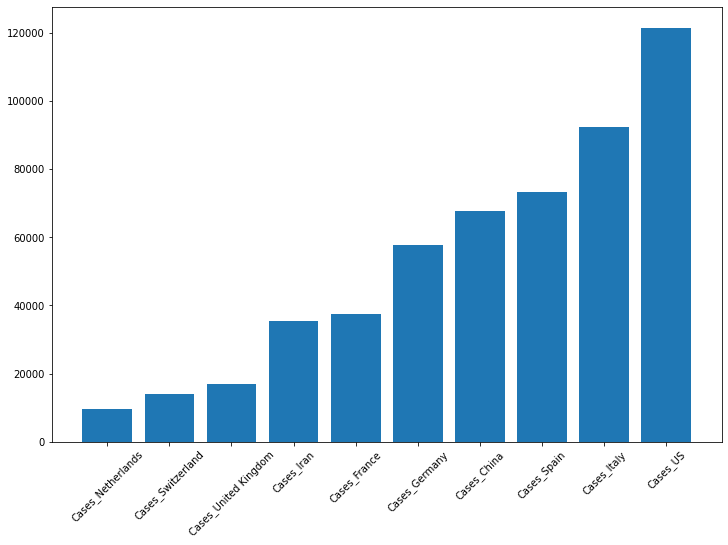

In [ ]:
def draw_bar():
    plt.figure(figsize=(12,8))
    height = most_affected_countries['Cases']
    bars = list_of_countires
    y_pos = np.arange(len(list_of_countires))
    plt.bar(y_pos, height, label='Liczba przypadków koronawirusa' )
    plt.xticks(y_pos, bars, rotation=45)
    plt.show()  

draw_bar()
 

Pobranie wartości indesku 10 państ i przypisanie im koloru




In [ ]:
def get_risk( src ):
    risk = list()
    colors = list()
    for i in range(0, len(list_for_barchart)):
        risk.append(  src.loc[list_for_barchart[i]]['Risk group'] )
        if (risk[i].astype(float) == 1.0 ):
            colors.append( 'r' )
        elif (risk[i].astype(float)  == 2.0):
            colors.append( 'y' )
        elif (risk[i].astype(float)  == 3.0):
            colors.append( 'g' )
    return risk,colors

risk_list , risk_colors = get_risk(df_I) 

In [ ]:
risk_list

[3.0, 3.0, 2.0, 1.0, 3.0, 3.0, 1.0, 2.0, 2.0, 3.0]

In [ ]:
risk_colors

['g', 'g', 'y', 'r', 'g', 'g', 'r', 'y', 'y', 'g']

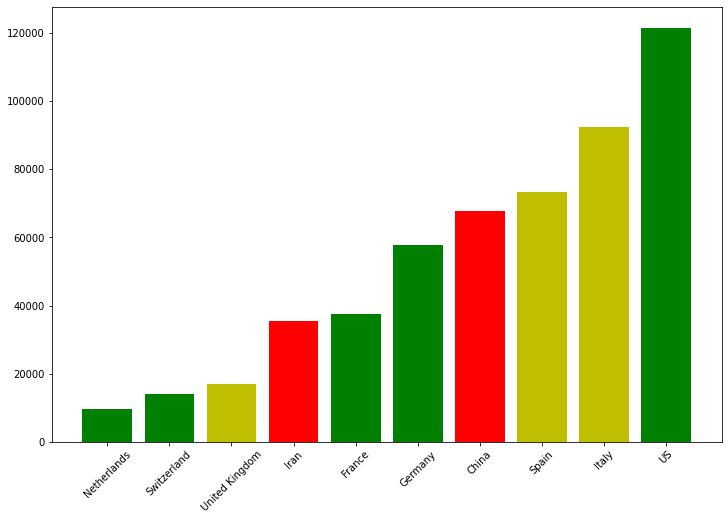

In [ ]:
def draw_bar():
    plt.figure(figsize=(12,8))
    height = most_affected_countries['Cases']
    bars = list_of_countires
    y_pos = np.arange(len(list_of_countires))
    plt.bar(y_pos, height, color = risk_colors, label='Liczba przypadków koronawirusa' )
    plt.xticks(y_pos, bars, rotation=45)
    plt.show()  

draw_bar()
 

Wyznaczanie rozwoju liczby zachorowań w kolejnych dniach dla 10 państw będących w szczycie epidemi


In [ ]:
def ten_countries( src ):
    
    base = src.loc[list_of_countires[0]]
    for i in range(1,len(list_of_countires)):
         pre = "_"
         nam1 = str(pre + list_of_countires[i-1])
         nam2 = str(pre + list_of_countires[i])
         base = pd.merge(base, src.loc[list_of_countires[i]], on='Date', suffixes=(nam1 ,nam2))
         list_of_countires[i-1] = "Cases" + nam1
    list_of_countires[i] = "Cases" + nam2
    return base

time_series = ten_countries(df_Infected)
time_series 

,Cases_Netherlands,Cases_Switzerland,Cases_United Kingdom,Cases_Iran,Cases_France,Cases_Germany,Cases_China,Cases_Spain,Cases_Italy,Cases_US
Date,,,,,,,,,,
1/22/20,0,0,0,0,0,0,1,0,0,1
1/22/20,0,0,0,0,0,0,14,0,0,1
1/22/20,0,0,0,0,0,0,6,0,0,1
1/22/20,0,0,0,0,0,0,1,0,0,1
1/22/20,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
3/28/20,9762,14076,4,35408,37575,57695,161,73235,92472,121478
3/28/20,9762,14076,4,35408,37575,57695,1,73235,92472,121478
3/28/20,9762,14076,4,35408,37575,57695,76,73235,92472,121478


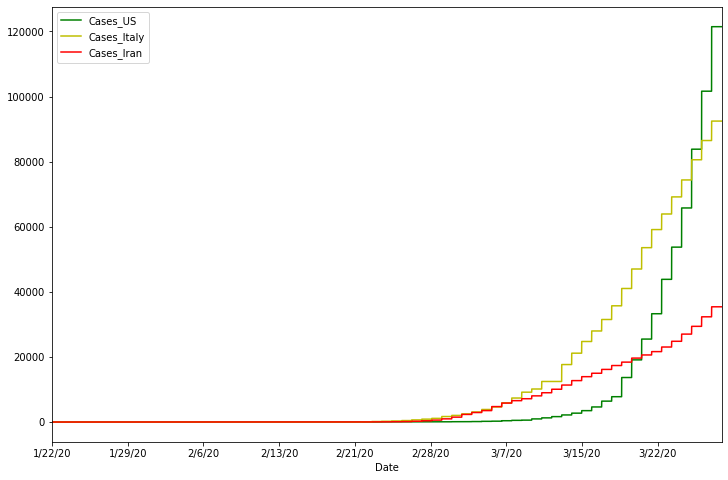

In [ ]:
time_series.plot( y =[ list_of_countires[9], list_of_countires[8], list_of_countires[3]] , figsize=(12, 8), kind = 'line' , color = [risk_colors[9], risk_colors[8], risk_colors[3] ]   )

Dane na temat 

In [ ]:
df_I.loc["Poland"]

Medical doctors (per 10 000 population)                9.767196
Hospital beds (per 10 000 population)                 16.169154
Current health expenditure (CHE) per capita in US$     2.950066
Points                                                28.886416
Risk group                                             2.000000
Name: Poland, dtype: float64

In [ ]:
poland = df_Infected.loc["Poland"]
poland = poland.groupby(['Cases']).max().tail(1)
poland

""
Cases
1638
